#### Initial imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Set processing parameters

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
USE_PARALLEL = False
res = 2

### Prep lists of input files

In [3]:
from glob import glob
import re
import pandas as pd
from random import sample, seed

In [7]:
avail_suffix = ['rgb', 'tpi', 'ndvi']

In [8]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set directories for training data and labels
DATA_FOLDER = './cnn_train_images_' + str(res) + 'cm/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels_' + str(res) + 'cm/{}_labels.tif'

In [9]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [10]:
df_tiles.value_counts('Train')

Train
1    76
0    57
dtype: int64

In [11]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[2:]) for y in all_ids]))

In [12]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.3)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [13]:
tile_ids = df_tiles[(df_tiles['trainer'] != 'Nick') &
                    (df_tiles['Digitize'] == 1)].apply(lambda x: '_'.join([x.Pasture, x.Tile]), axis=1)
#all_tiles#
[x for x in all_tiles if x not in tile_ids.to_list()]

[]

In [14]:
[x for x in tile_ids.to_list() if x not in all_tiles]

[]

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io

In [16]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)




### Augmentations

In [17]:
import albumentations as albu
import random

In [18]:
def get_training_augmentation():
    win_size = 32 * random.randint(7, 10)
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.0, rotate_limit=45, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=win_size, min_width=win_size, always_apply=True, border_mode=4),
        albu.RandomCrop(height=win_size, width=win_size, always_apply=True),

        #albu.GaussNoise(p=0.2, var_limit=1.0),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
        #    [
        #        #albu.CLAHE(p=1), # required int8 images
        #        albu.RandomBrightnessContrast(p=1),
        #        #albu.RandomGamma(p=1),
        #        #albu.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=(3, 7), p=1),
                albu.MotionBlur(blur_limit=(3, 7), p=1),
            ],
            p=0.25,
        ),
    ]
    return albu.Compose(train_transform)

### Create preprocessing function from training data stats

In [19]:
import torch
import numpy as np

In [20]:
CLASSES = ['burrow']

In [21]:
image_stats = {
    'rgb': {'min': 0.0,
            'max': 255.0},
    'tpi': {'min': -0.10,
            'max': 0.40},
    'ndvi': {'min': 0.0,
             'max': 1.0}
}

In [22]:
for suffix_list in []:
    train_dataset = Dataset(
        train_ids,
        suffix_list,
        DATA_FOLDER,
        LABEL_FOLDER,
        classes=CLASSES)
    #train_dataset[0][0].cpu().numpy().shape
    min_list = []
    max_list = []
    for i in range(len(train_dataset)):
        min_list.append(np.min(train_dataset[i][0].cpu().numpy()))
        max_list.append(np.max(train_dataset[i][0].cpu().numpy()))
    image_stats[suffix_list[0]] = {
        'min': np.min(min_list),
        'max': np.max(max_list)
    }

In [23]:
df_image_stats = pd.DataFrame(image_stats).reset_index().rename(
    columns={'index': 'stat'})
df_image_stats.to_csv('./_utils/image_stats_' + str(res) + 'cm.csv', index=False)

In [44]:
image_stats

{'rgb': {'min': 0.0, 'max': 255.0},
 'tpi': {'min': -0.1, 'max': 0.4},
 'ndvi': {'min': 0.0, 'max': 1.0}}

In [24]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)
    
        

In [25]:
suffix_list = ['ndvi']
train_dataset = Dataset(
        train_ids,
        suffix_list,
        DATA_FOLDER,
        LABEL_FOLDER,
        #augmentation=get_training_augmentation(),
        preprocessing=True,
        classes=CLASSES)
min_list_tmp = []
for i in range(len(train_dataset)):
    min_list_tmp.append(np.min(train_dataset[i][0].cpu().numpy()))

In [26]:
np.min(min_list_tmp)

0.0

### Create and train model

In [27]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import torch.nn as nn
import gc

In [28]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cuda'# 'cpu'# 
VALID_THRESH = 0.01
CYCLE_EPOCHS = 6 # must be an even number as currently coded. Should be between 4 and 16
BATCH_SIZE = 11
MIN_CYCLES = 2
MAX_EPOCHS = 60 # should be evenly divided by CYCLE_EPOCHS
CYCLE_PATIENCE = 2
#PATIENCE = 5

In [29]:
import itertools
#list(itertools.combinations(avail_suffix, len(avail_suffix)))
suffix_combinations = list()
for n in range(1, len(avail_suffix) + 1):
    suffix_combinations += list(itertools.combinations(avail_suffix, n))

In [32]:
suffix_combinations = [x for x in suffix_combinations if x != ('tpi', 'ndvi')]
suffix_combinations

[('rgb',),
 ('tpi',),
 ('ndvi',),
 ('rgb', 'tpi'),
 ('rgb', 'ndvi'),
 ('rgb', 'tpi', 'ndvi')]

In [40]:
lr_list = np.sort([0.1**i for i in range(1, 6)] + [0.25**i for i in range(4, 7)] + [0.5**i for i in range(3, 10)] + [0.25, 0.5])
lr_list = list(dict.fromkeys(lr_list))
lr_list

array([1.00000000e-05, 1.00000000e-04, 2.44140625e-04, 9.76562500e-04,
       1.00000000e-03, 1.95312500e-03, 3.90625000e-03, 3.90625000e-03,
       7.81250000e-03, 1.00000000e-02, 1.56250000e-02, 3.12500000e-02,
       6.25000000e-02, 1.00000000e-01, 1.25000000e-01, 2.50000000e-01,
       5.00000000e-01])

In [41]:
test_lr = True
if test_lr:
    df_out = pd.DataFrame(columns=['model', 'LR', 'F-score'])
    idx_i = 0
    for mod in ['deeplabplus']:
        print('\n\n----------------------------------------------------------')
        print('----------------------------------------------------------')
        print('Now running model: ' + mod)
        print('----------------------------------------------------------')
        for suffix_sub in [['rgb', 'tpi', 'ndvi']]:
            suffix_list = list(suffix_sub)
            print('\n\n----------------------------------------------------------')
            print(suffix_list)
            train_dataset = Dataset(
                train_ids,
                suffix_list,
                DATA_FOLDER,
                LABEL_FOLDER,
                augmentation=get_training_augmentation(),
                preprocessing=True,
                classes=CLASSES)

            train_loader = DataLoader(train_dataset, batch_size=11, shuffle=True,
                                      drop_last=True, num_workers=8, pin_memory=False)

            for lr_i in lr_list:
                # create segmentation model with pretrained encoder
                if mod == 'deeplabplus':
                    model = smp.DeepLabV3Plus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'fpn':
                    model = smp.FPN(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'manet':
                    model = smp.MAnet(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'unetplus':
                    model = smp.UnetPlusPlus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                else:
                    print('ERROR: model "' + mod + '" not found!')
                    break

                if USE_PARALLEL:
                    model = nn.DataParallel(model)

                preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                loss = smp.losses.MCCLoss()
                loss.__name__ = 'mccloss'
                metrics = [
                    utils.metrics.IoU(threshold=0.5),
                    utils.metrics.Accuracy(threshold=0.5),
                    utils.metrics.Precision(threshold=0.5),
                    utils.metrics.Recall(threshold=0.5),
                    utils.metrics.Fscore(threshold=0.5)
                ]

                optimizer = torch.optim.SGD([ 
                    dict(params=model.parameters(), lr=lr_i, momentum=0.8),
                ])

                # create epoch runners 
                # it is a simple loop of iterating over dataloader`s samples
                train_epoch = utils.train.TrainEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics, 
                    optimizer=optimizer,
                    device=DEVICE,
                    verbose=True,
                )

                # train model for 5 epochs

                max_score = 0
                max_score_train = 0
                no_improve = 0

                print('-----------------------')
                print('LR = ' + str(lr_i))
                for i in range(1, CYCLE_EPOCHS + 1):
                    print('\nEpoch: {}'.format(i))
                    train_logs = train_epoch.run(train_loader)
                    train_logs['fscore_old'] = train_logs['fscore']
                    beta = 1.0
                    train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])
                df_tmp = pd.DataFrame({
                    'model': mod,
                    'LR': lr_i,
                    'F-score': train_logs['fscore'],
                    'resolution': 2.0,
                    'inputs': '_'.join(suffix_sub),
                }, index=[idx_i])
                df_out = pd.concat([df_out, df_tmp])
                idx_i += 1


                del model, train_epoch
                gc.collect()
                torch.cuda.empty_cache()
            df_out.to_csv('./_utils/lr_step_testing.csv', index=False)



----------------------------------------------------------
----------------------------------------------------------
Now running model: deeplabplus
----------------------------------------------------------


----------------------------------------------------------
['rgb', 'tpi', 'ndvi']
-----------------------
LR = 1.0000000000000003e-05

Epoch: 1
train: 100%|█| 28/28 [00:05<00:00,  5.17it/s, mccloss - 1.001, iou_score - 0.01297, accuracy - 0.5963, precision - 0.01325, recall - 0.41

Epoch: 2
train: 100%|█| 28/28 [00:05<00:00,  5.32it/s, mccloss - 1.001, iou_score - 0.01257, accuracy - 0.5959, precision - 0.01287, recall - 0.37

Epoch: 3
train: 100%|█| 28/28 [00:05<00:00,  5.38it/s, mccloss - 1.002, iou_score - 0.01202, accuracy - 0.5941, precision - 0.01235, recall - 0.37

Epoch: 4
train: 100%|█| 28/28 [00:05<00:00,  5.37it/s, mccloss - 1.002, iou_score - 0.01228, accuracy - 0.5931, precision - 0.01259, recall - 0.39

Epoch: 5
train: 100%|█| 28/28 [00:05<00:00,  5.28it/s, mcclos

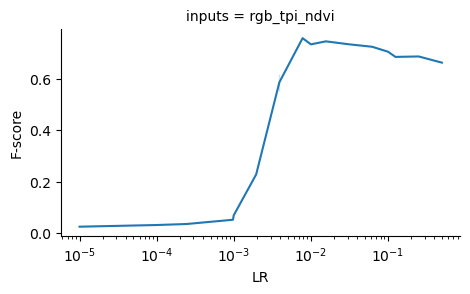

In [42]:
df_out = pd.read_csv('./_utils/lr_step_testing.csv')
import seaborn as sns
g = sns.FacetGrid(hue='model', col='inputs', data=df_out, height=3, aspect=1.6)
g.map_dataframe(sns.lineplot, x='LR', y='F-score')
#g.set_xlim((0.0001, 0.02))
g.set(xscale="log")
plt.show()

In [43]:
df_out

,model,LR,F-score,resolution,inputs
0,deeplabplus,0.000010,0.023703,2.0,rgb_tpi_ndvi
1,deeplabplus,0.000100,0.030251,2.0,rgb_tpi_ndvi
2,deeplabplus,0.000244,0.034175,2.0,rgb_tpi_ndvi
3,deeplabplus,0.000977,0.050831,2.0,rgb_tpi_ndvi
4,deeplabplus,0.001000,0.068221,2.0,rgb_tpi_ndvi
5,deeplabplus,0.001953,0.227686,2.0,rgb_tpi_ndvi
6,deeplabplus,0.003906,0.553726,2.0,rgb_tpi_ndvi
7,deeplabplus,0.003906,0.620904,2.0,rgb_tpi_ndvi
8,deeplabplus,0.007812,0.759428,2.0,rgb_tpi_ndvi
9,deeplabplus,0.010000,0.735267,2.0,rgb_tpi_ndvi


In [45]:
for mod in ['deeplabplus']:
    print('\n\n----------------------------------------------------------')
    print('----------------------------------------------------------')
    print('Now running model: ' + mod)
    print('----------------------------------------------------------')
    outDIR = './cnn_results_' + mod + '_' + str(res) + 'cm/'
    if not os.path.exists(outDIR):
        os.mkdir(outDIR)
    for suffix_sub in suffix_combinations:
        suffix_list = list(suffix_sub)
        print('\n\n----------------------------------------------------------')
        print(suffix_list)
        if os.path.exists(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt'):
            print('skipping - already trained.')
            continue
        else:
            train_dataset = Dataset(
                train_ids,
                suffix_list,
                DATA_FOLDER,
                LABEL_FOLDER,
                augmentation=get_training_augmentation(),
                preprocessing=True,
                classes=CLASSES)

            valid_dataset = Dataset(
                valid_ids,
                suffix_list,
                DATA_FOLDER,
                LABEL_FOLDER,
                #augmentation=get_validation_augmentation(),
                preprocessing=True,
                classes=CLASSES)


            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                      drop_last=True, num_workers=8, pin_memory=False)
            valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=False)

            # create segmentation model with pretrained encoder
            if mod == 'deeplabplus':
                model = smp.DeepLabV3Plus(
                    encoder_name=ENCODER, 
                    encoder_weights=ENCODER_WEIGHTS, 
                    classes=len(CLASSES), 
                    activation=ACTIVATION,
                    in_channels=train_dataset[0][0].shape[0],
                )
            elif mod == 'fpn':
                model = smp.FPN(
                    encoder_name=ENCODER, 
                    encoder_weights=ENCODER_WEIGHTS, 
                    classes=len(CLASSES), 
                    activation=ACTIVATION,
                    in_channels=train_dataset[0][0].shape[0],
                )
            elif mod == 'manet':
                model = smp.MAnet(
                    encoder_name=ENCODER, 
                    encoder_weights=ENCODER_WEIGHTS, 
                    classes=len(CLASSES), 
                    activation=ACTIVATION,
                    in_channels=train_dataset[0][0].shape[0],
                )
            elif mod == 'unetplus':
                model = smp.UnetPlusPlus(
                    encoder_name=ENCODER, 
                    encoder_weights=ENCODER_WEIGHTS, 
                    classes=len(CLASSES), 
                    activation=ACTIVATION,
                    in_channels=train_dataset[0][0].shape[0],
                )
            else:
                print('ERROR: model "' + mod + '" not found!')
                break
                
            if USE_PARALLEL:
                model = nn.DataParallel(model)

            preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

            # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
            # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

            loss = smp.losses.MCCLoss()
            loss.__name__ = 'mccloss'
            metrics = [
                utils.metrics.IoU(threshold=0.5),
                utils.metrics.Accuracy(threshold=0.5),
                utils.metrics.Precision(threshold=0.5),
                utils.metrics.Recall(threshold=0.5),
                utils.metrics.Fscore(threshold=0.5)
            ]

            #optimizer = torch.optim.Adam([ 
            #    dict(params=model.parameters(), lr=0.0001),
            #])
            
            optimizer = torch.optim.SGD([ 
                dict(params=model.parameters(), lr=1.0e-02),
            ])
            
            #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10e-3, 
            #                                                steps_per_epoch=len(train_loader), epochs=MAX_EPOCHS,
            #                                                three_phase=True,
            #                                                verbose=False)
            
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1.0e-03, max_lr=1.0e-02,
                                                          step_size_up=len(train_dataset) * (CYCLE_EPOCHS/2) / BATCH_SIZE,
                                                          mode='triangular2')

            # create epoch runners 
            # it is a simple loop of iterating over dataloader`s samples
            train_epoch = utils.train.TrainEpoch(
                model, 
                loss=loss, 
                metrics=metrics, 
                optimizer=optimizer,
                oclr_scheduler=scheduler,
                device=DEVICE,
                verbose=True,
            )

            valid_epoch = utils.train.ValidEpoch(
                model, 
                loss=loss, 
                metrics=metrics, 
                device=DEVICE,
                verbose=True,
            )

            # train model for up to 60 epochs

            max_score = 0
            max_score_train = 0
            no_improve = 0
            for i in range(1, MAX_EPOCHS+1):
                print('\nEpoch: {}'.format(i))
                print('Learning rate: ' + str(optimizer.param_groups[0]['lr']))
                train_logs = train_epoch.run(train_loader)
                valid_logs = valid_epoch.run(valid_loader)
                valid_logs['fscore_old'] = valid_logs['fscore']
                beta = 1.0
                valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])
                train_logs['fscore_old'] = train_logs['fscore']
                beta = 1.0
                train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])
                
                if i%CYCLE_EPOCHS == 0:
                    if (valid_logs['fscore'] - max_score) > VALID_THRESH:
                        max_score = valid_logs['fscore']
                        max_score_train = train_logs['fscore']
                        torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + '.pth')
                        valid_logs['best_epoch'] = i
                        valid_logs['resolution'] = float(res)
                        best_valid_logs = valid_logs.copy()
                        print('Model saved!')
                        no_improve = 0
                    else:
                        no_improve += 1
                        print('No improvement in ' + str(no_improve) + ' cycles. Model not saved.')

                    if i > (MIN_CYCLES * CYCLE_EPOCHS):
                        if no_improve >= CYCLE_PATIENCE:
                            if (train_logs['fscore'] - max_score_train) < 0.1:
                                print('More than ' + str(CYCLE_PATIENCE) + ' cycles without validation improvement while training improvement < 0.1...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                            elif no_improve == CYCLE_PATIENCE * 2:
                                print(str(CYCLE_PATIENCE * 2) + ' cycles without validation improvement...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                
                if i == MAX_EPOCHS:
                    print('maximum number of epochs reached...ending training')
                    with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
                                data.write(str(best_valid_logs))

                """if i > MIN_EPOCHS:
                    if no_improve >= PATIENCE:
                        if (train_logs['fscore'] - max_score_train) < 0.1:
                            print('More than 5 epochs without validation improvement while learning rate <= 1e-5 and training improvement < 0.05...ending training')
                            with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
                                data.write(str(best_valid_logs))
                            break
                        elif (train_logs['fscore'] - max_score_train) < 0.15 and no_improve == 15:
                            print('15 epochs without validation improvement while learning rate <= 1e-5...ending training')
                            with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
                                data.write(str(best_valid_logs))
                            break
                if i == 60:
                    with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_validation.txt','w') as data: 
                                data.write(str(best_valid_logs))

                if i%15 == 0:
                    no_improve = 0
                    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
                    print('Decrease decoder learning rate by factor of 10')"""

            del model, train_epoch, valid_epoch
            gc.collect()
            torch.cuda.empty_cache()



----------------------------------------------------------
----------------------------------------------------------
Now running model: deeplabplus
----------------------------------------------------------


----------------------------------------------------------
['rgb']

Epoch: 1
Learning rate: 0.001
train: 100%|█| 28/28 [00:03<00:00,  7.71it/s, mccloss - 0.9821, iou_score - 0.02002, accuracy - 0.2766, precision - 0.02011, recall - 0.8
valid: 100%|█| 133/133 [00:01<00:00, 71.55it/s, mccloss - 0.9949, iou_score - 0.01012, accuracy - 0.1055, precision - 0.01012, recall - 0

Epoch: 2
Learning rate: 0.004000000000000002
train: 100%|█| 28/28 [00:03<00:00,  8.24it/s, mccloss - 0.9068, iou_score - 0.04654, accuracy - 0.6067, precision - 0.04672, recall - 0.9
valid: 100%|█| 133/133 [00:01<00:00, 73.78it/s, mccloss - 0.9663, iou_score - 0.01521, accuracy - 0.4526, precision - 0.01522, recall - 0

Epoch: 3
Learning rate: 0.006999999999999999
train: 100%|█| 28/28 [00:03<00:00,  8.12it/s, 

In [46]:
print('All processing complete!')

All processing complete!
